# reviewers request was to use beta-binomial model instead of simple binomial test. 
This requires using apeglm, which is an R package. this script converts the counts so that it's ready for apeglm

In [1]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
from functools import partial
import glob
import os
import math
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import gzip
import io
import pickle
from functools import reduce

plt.rcParams['svg.fonttype'] = 'none'
base_dir = "http://bartzabel.ls.manchester.ac.uk/orozcolab/SNP2Mechanism/"


In [3]:
metadata_ATAC = pd.read_csv(f"{base_dir}/metadata/cleaned_ATAC_metadata.csv", index_col=0)
def read_vcf(path):
    with gzip.open(path, 'rt') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

In [49]:
def extract_numbers(x):
    # split the string by ':'
    numbers = x.split(':')
    # extract the last two numbers
    num1, num2 = numbers[-1].split(',')
    return int(num1), int(num2)


def get_data_per_sample(ID_sample):
    dataframes = []

    # loop through the 22 chromosomes
    for chrom in range(1, 23):
        # open the dataframe for each chromosome
        test_file = f".local/called_bcf/{ID_sample}/{ID_sample}_chr{chrom}_filt_annotated.vcf.gz"
        df = read_vcf(test_file)
        # add the dataframe to the list
        dataframes.append(df)

    # concatenate the dataframes
    result = pd.concat(dataframes).reset_index(drop = True)

    result = result.drop(["FILTER", "QUAL", "INFO", "FORMAT"], axis = 1)
    result = result.rename(columns={result.columns[-1]: ID_sample})

    result[[ID_sample + '_A', ID_sample + '_B']] = pd.DataFrame(result[ID_sample].apply(extract_numbers).tolist(), columns=[ID_sample + '_A', ID_sample + '_B'])
    
    # filter rows here
    def get_good_row(row):
        if (row[ID_sample + '_A'] > 2) and (row[ID_sample + '_B'] > 2): # either of them needs to be above two
            tot = row[ID_sample + '_A']+row[ID_sample + '_B']
            if (row[ID_sample + '_A']/tot > 0.05) and (row[ID_sample + '_B']/tot > 0.05): # both of them need to be above 5%, this is in case actual counts are very high
                return True
        return False
    result = result[result.parallel_apply(get_good_row, axis = 1)]
    return result

# all_results = {}
# for sample in metadata_ATAC["id"].to_list():
#     result = get_data_per_sample(sample)
#     all_results[sample] = result

#     print(sample, len(result))

In [50]:
# pickle.dump(all_results, open(f".local/ATAC_all_counts_called.pk", "wb"))

In [4]:
all_results = pickle.load(open(f".local/ATAC_all_counts_called.pk", "rb"))

In [52]:
# Iterate through the dictionary of dataframes
dfs = [df.iloc[:, :5] for key, df in all_results.items()]
# Concatenate the dataframes
all_called_SNPs = pd.concat(dfs, ignore_index=True)

# Drop duplicates from the merged dataframe
all_called_SNPs = all_called_SNPs.drop_duplicates()


In [53]:
for idx,df in all_results.items():
    all_called_SNPs = all_called_SNPs.merge(df[["CHROM", "POS", "REF", "ALT", f"{idx}_A",f"{idx}_B"]], on=["CHROM", "POS", "REF", "ALT"], how = "left")

In [54]:
# filter SNPs that have less than 3 samples with counts
all_called_SNPs = all_called_SNPs.dropna(thresh=11)

In [55]:
all_called_SNPs

,CHROM,POS,ID,REF,ALT,NRHV151_CD4_A,NRHV151_CD4_B,NRHV151_CD8_A,NRHV151_CD8_B,NRHV321_CD4_A,...,PSA4958CD4SF_A,PSA4958CD4SF_B,PSA4962CD4_A,PSA4962CD4_B,PSA4966CD8_A,PSA4966CD8_B,PSA5037CD8_A,PSA5037CD8_B,PSA5040CD4_A,PSA5040CD4_B
0,chr1,905373,rs4970382,T,C,3.0,10.0,5.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,9.0,NaN,NaN
1,chr1,940256,.,C,T,3.0,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,940387,.,T,G,9.0,8.0,10.0,14.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,960891,rs112905931,C,T,6.0,12.0,12.0,14.0,NaN,...,7.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,15.0
4,chr1,976215,rs7417106,A,G,52.0,26.0,52.0,13.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243918,chr7,5241368,rs34312922,T,C,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,4.0,6.0,6.0
250095,chr11,1921984,rs2734498,C,T,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6.0,5.0,NaN,NaN,NaN,NaN
250591,chr11,64153109,rs115870778,C,T,NaN,NaN,NaN,NaN,NaN,...,8.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
258651,chr5,181188406,.,C,A,NaN,NaN,NaN,NaN,NaN,...,17.0,3.0,NaN,NaN,15.0,6.0,NaN,NaN,NaN,NaN


In [56]:
tot_counts = pd.DataFrame()
ase_counts = pd.DataFrame()
for sample in metadata_ATAC["id"]:
    tot_counts[sample] = all_called_SNPs[f"{sample}_A"] + all_called_SNPs[f"{sample}_B"]
    ase_counts[sample] = all_called_SNPs[f"{sample}_A"]
tot_counts[["CHROM", "POS", "ID", "REF", "ALT"]] = all_called_SNPs[["CHROM", "POS", "ID", "REF", "ALT"]]
tot_counts = tot_counts.dropna(thresh=8)
ase_counts = ase_counts.dropna(thresh=3)

tot_counts[["CHROM", "POS", "ID", "REF", "ALT"]].to_csv(f".local/ATAC_goingtoR/ATAC_ALL_SNPs.csv")
tot_counts = tot_counts.drop(["CHROM", "POS", "ID", "REF", "ALT"], axis = 1)
tot_counts.to_csv(f".local/ATAC_goingtoR/ATAC_ALL_tot_counts.csv")
ase_counts.to_csv(f".local/ATAC_goingtoR/ATAC_ALL_ASE_counts.csv")

/tmp/ipykernel_3560671/3337894714.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tot_counts[sample] = all_called_SNPs[f"{sample}_A"] + all_called_SNPs[f"{sample}_B"]
/tmp/ipykernel_3560671/3337894714.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ase_counts[sample] = all_called_SNPs[f"{sample}_A"]
/tmp/ipykernel_3560671/3337894714.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once u

In [58]:
tot_counts = pd.DataFrame()
ase_counts = pd.DataFrame()
for sample in metadata_ATAC[(metadata_ATAC["cell_type"] == "CD4") | (metadata_ATAC["cell_type"] == "CD4_SF")]["id"]:
    tot_counts[sample] = all_called_SNPs[f"{sample}_A"] + all_called_SNPs[f"{sample}_B"]
    ase_counts[sample] = all_called_SNPs[f"{sample}_A"]
tot_counts[["CHROM", "POS", "ID", "REF", "ALT"]] = all_called_SNPs[["CHROM", "POS", "ID", "REF", "ALT"]]
tot_counts = tot_counts.dropna(thresh=8)
ase_counts = ase_counts.dropna(thresh=3)

tot_counts[["CHROM", "POS", "ID", "REF", "ALT"]].to_csv(f".local/ATAC_goingtoR/ATAC_CD4_SNPs.csv")
tot_counts = tot_counts.drop(["CHROM", "POS", "ID", "REF", "ALT"], axis = 1)
tot_counts.to_csv(f".local/ATAC_goingtoR/ATAC_CD4_tot_counts.csv")
ase_counts.to_csv(f".local/ATAC_goingtoR/ATAC_CD4_ASE_counts.csv")

In [59]:
tot_counts = pd.DataFrame()
ase_counts = pd.DataFrame()
for sample in metadata_ATAC[(metadata_ATAC["cell_type"] == "CD8") | (metadata_ATAC["cell_type"] == "CD8_SF")]["id"]:
    tot_counts[sample] = all_called_SNPs[f"{sample}_A"] + all_called_SNPs[f"{sample}_B"]
    ase_counts[sample] = all_called_SNPs[f"{sample}_A"]
tot_counts[["CHROM", "POS", "ID", "REF", "ALT"]] = all_called_SNPs[["CHROM", "POS", "ID", "REF", "ALT"]]
tot_counts = tot_counts.dropna(thresh=8)
ase_counts = ase_counts.dropna(thresh=3)

tot_counts[["CHROM", "POS", "ID", "REF", "ALT"]].to_csv(f".local/ATAC_goingtoR/ATAC_CD8_ALL_SNPs.csv")
tot_counts = tot_counts.drop(["CHROM", "POS", "ID", "REF", "ALT"], axis = 1)
tot_counts.to_csv(f".local/ATAC_goingtoR/ATAC_CD8_tot_counts.csv")
ase_counts.to_csv(f".local/ATAC_goingtoR/ATAC_CD8_ASE_counts.csv")

## load back the results from apeglm and add the old stats that were generated

In [14]:
svals = pd.read_csv(".local/ATAC_goingtoR/apeglm_results_CD4_w.txt").reset_index()
results = pd.read_csv(".local/ATAC_goingtoR/ATAC_CD4_SNPs.csv", index_col = 0).reset_index(drop = True)
results["svalues_betabinom"] = svals["x"]

In [16]:
old_results = pd.read_csv(f"{base_dir}/atac/allelic_imbalance/all_SNPs_CD4_all.csv", index_col=0)

In [17]:
df = old_results.merge(results, on = ["CHROM", "POS", "ID", "REF", "ALT"], how = "left")

In [25]:
sum(df["svalues_betabinom"] < 0.10)

11416

In [27]:
df.to_csv(".local/results/ATAC_CD4_allelic_imbalance_with_betabinom.csv")

In [28]:
svals = pd.read_csv(".local/ATAC_goingtoR/apeglm_results_CD8_w.txt").reset_index()
results = pd.read_csv(".local/ATAC_goingtoR/ATAC_CD8_ALL_SNPs.csv", index_col = 0).reset_index(drop = True)
results["svalues_betabinom"] = svals["x"]

In [29]:
old_results = pd.read_csv(f"{base_dir}/atac/allelic_imbalance/all_SNPs_CD8_all.csv", index_col=0)

In [30]:
df = old_results.merge(results, on = ["CHROM", "POS", "ID", "REF", "ALT"], how = "left")

In [31]:
df.to_csv(".local/results/ATAC_CD8_allelic_imbalance_with_betabinom.csv")

In [32]:
svals = pd.read_csv(".local/ATAC_goingtoR/apeglm_results_ALL_w.txt").reset_index()
results = pd.read_csv(".local/ATAC_goingtoR/ATAC_ALL_SNPs.csv", index_col = 0).reset_index(drop = True)
results["svalues_betabinom"] = svals["x"]

In [33]:
old_results = pd.read_csv(f"{base_dir}/atac/allelic_imbalance/all_SNPs_all.csv", index_col=0)
df = old_results.merge(results, on = ["CHROM", "POS", "ID", "REF", "ALT"], how = "left")

In [34]:
df.to_csv(".local/results/ATAC_ALL_allelic_imbalance_with_betabinom.csv")

In [35]:
sum(df["svalues_betabinom"] < 0.10)

17172

In [36]:
sum(results["svalues_betabinom"] < 0.10)

17094

## quick venn diagram

In [2]:
df_ALL = pd.read_csv(".local/results/ATAC_ALL_allelic_imbalance_with_betabinom.csv.gz", index_col = 0)
df_CD4 = pd.read_csv(".local/results/ATAC_CD4_allelic_imbalance_with_betabinom.csv.gz", index_col = 0)
df_CD8 = pd.read_csv(".local/results/ATAC_CD8_allelic_imbalance_with_betabinom.csv.gz", index_col = 0)

In [3]:
df_CD4["unique_id"] = df_CD4["CHROM"].astype(str) + "_" + df_CD4["POS"].astype(str) + "_" + df_CD4["ID"]
df_CD8["unique_id"] = df_CD8["CHROM"].astype(str) + "_" + df_CD8["POS"].astype(str) + "_" + df_CD8["ID"]
df_ALL["unique_id"] = df_ALL["CHROM"].astype(str) + "_" + df_ALL["POS"].astype(str) + "_" + df_ALL["ID"]

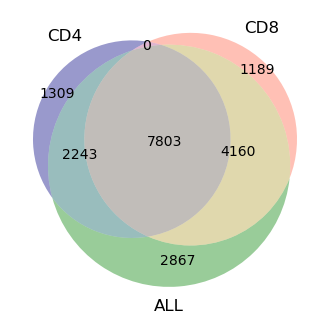

In [4]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn3

# Define the sets
set1 = set(df_CD4[df_CD4["svalues_betabinom"] < 0.1]["unique_id"].to_list())
set2 = set(df_CD8[df_CD8["svalues_betabinom"] < 0.1]["unique_id"].to_list())
set3 = set(df_ALL[df_ALL["svalues_betabinom"] < 0.1]["unique_id"].to_list())

fig, ax = plt.subplots(1,1,figsize=(4,4))
# Create the Venn diagram
v = venn3([set1, set2, set3], set_colors=["navy","tomato", "green"],set_labels=('CD4', 'CD8', "ALL"), ax=ax)

# Show the plot
fig.savefig(f"figures/atac_venn_allele_associated.svg", dpi = 600)